In [302]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import models
from keras import layers
import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split
from keras import regularizers

In [303]:
from google.colab import files
uploaded=files.upload()

Saving CarPrice_Assignment.csv to CarPrice_Assignment (9).csv


In [304]:
import io
df=pd.read_csv(io.BytesIO(uploaded["CarPrice_Assignment.csv"]))

In [305]:
df.info()
df.size
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

(205, 26)

In [306]:
df[df.duplicated()]

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price


In [307]:
normalized_data=df.copy()

**One Hot Encoding**

In [308]:
# Since 10 coulmns are object types so we have to encode and concatenate them 
#all = pd.get_dummies(normalized_data, columns=["fueltype", "aspiration", "doornumber", "carbody","drivewheel", "enginelocation","enginetype", "cylindernumber"]).astype(dtype="float64")

#column2= pd.get_dummies(normalized_data.iloc[:, 2:3]).astype(dtype="float64")
column3= pd.get_dummies(normalized_data.iloc[:, 3:4]).astype(dtype="float64")
column4= pd.get_dummies(normalized_data.iloc[:, 4:5]).astype(dtype="float64")
column5= pd.get_dummies(normalized_data.iloc[:, 5:6]).astype(dtype="float64")
column6= pd.get_dummies(normalized_data.iloc[:, 6:7]).astype(dtype="float64")
column7= pd.get_dummies(normalized_data.iloc[:, 7:8]).astype(dtype="float64")
column8= pd.get_dummies(normalized_data.iloc[:, 8:9]).astype(dtype="float64")
column14= pd.get_dummies(normalized_data.iloc[:, 14:15]).astype(dtype="float64")
column15= pd.get_dummies(normalized_data.iloc[:, 15:16]).astype(dtype="float64")
column17= pd.get_dummies(normalized_data.iloc[:, 17:18]).astype(dtype="float64")


In [309]:
#Deleting the original columns
normalized_data.drop(columns=["CarName", "fueltype", "aspiration", "doornumber", "carbody","drivewheel", "enginelocation", "enginetype", "cylindernumber", "fuelsystem"], axis=1, inplace=True)
normalized_data.drop(columns=["car_ID", "symboling"], axis=1, inplace=True)

In [310]:
normalized_data.head()

,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495.0
1,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500.0
2,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,16500.0
3,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,24,30,13950.0
4,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,18,22,17450.0


**Preparing the Training data**

In [311]:
x_data =pd.concat([ column3, column4, column5, column6, column7, column8, column14, column15, column17, normalized_data], axis=1)

In [312]:
x_data.head()


,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,doornumber_four,doornumber_two,carbody_convertible,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,drivewheel_4wd,drivewheel_fwd,drivewheel_rwd,enginelocation_front,enginelocation_rear,enginetype_dohc,enginetype_dohcv,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,cylindernumber_eight,cylindernumber_five,cylindernumber_four,cylindernumber_six,cylindernumber_three,cylindernumber_twelve,cylindernumber_two,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495.0
1,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500.0
2,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,16500.0
3,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,24,30,13950.0
4,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,18,22,17450.0


**Normalizing the Data**

In [313]:
mean_new=x_data.mean(axis=0)
std_new=x_data.std(axis=0)
x_data -= mean_new
x_data /=std_new

In [314]:
x_data.head()

,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,doornumber_four,doornumber_two,carbody_convertible,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,drivewheel_4wd,drivewheel_fwd,drivewheel_rwd,enginelocation_front,enginelocation_rear,enginetype_dohc,enginetype_dohcv,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,cylindernumber_eight,cylindernumber_five,cylindernumber_four,cylindernumber_six,cylindernumber_three,cylindernumber_twelve,cylindernumber_two,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,-0.327995,0.327995,0.468149,-0.468149,-1.127628,1.127628,5.744987,-0.201025,-0.718324,-0.936183,-0.371768,-0.213762,-1.185276,1.299649,0.121569,-0.121569,4.000610,-0.069843,-0.248743,-1.607428,-0.28029,-0.259573,-0.140725,-0.157728,-0.237538,0.536560,-0.363249,-0.069843,-0.069843,-0.140725,-0.237538,-0.687389,-0.121569,-0.327995,-0.069843,1.084016,-0.213762,-0.069843,-1.686643,-0.425480,-0.842719,-2.015483,-0.014531,0.074267,0.517804,-1.834886,-0.287645,0.174057,-0.262318,-0.644974,-0.544725,0.027324
1,-0.327995,0.327995,0.468149,-0.468149,-1.127628,1.127628,5.744987,-0.201025,-0.718324,-0.936183,-0.371768,-0.213762,-1.185276,1.299649,0.121569,-0.121569,4.000610,-0.069843,-0.248743,-1.607428,-0.28029,-0.259573,-0.140725,-0.157728,-0.237538,0.536560,-0.363249,-0.069843,-0.069843,-0.140725,-0.237538,-0.687389,-0.121569,-0.327995,-0.069843,1.084016,-0.213762,-0.069843,-1.686643,-0.425480,-0.842719,-2.015483,-0.014531,0.074267,0.517804,-1.834886,-0.287645,0.174057,-0.262318,-0.644974,-0.544725,0.403473
2,-0.327995,0.327995,0.468149,-0.468149,-1.127628,1.127628,-0.173216,-0.201025,1.385339,-0.936183,-0.371768,-0.213762,-1.185276,1.299649,0.121569,-0.121569,-0.248743,-0.069843,-0.248743,-1.607428,-0.28029,3.833691,-0.140725,-0.157728,-0.237538,-1.854632,2.739503,-0.069843,-0.069843,-0.140725,-0.237538,-0.687389,-0.121569,-0.327995,-0.069843,1.084016,-0.213762,-0.069843,-0.706865,-0.230948,-0.190101,-0.542200,0.513625,0.602571,-2.399008,0.684271,-0.287645,1.261448,-0.262318,-0.950684,-0.689938,0.403473
3,-0.327995,0.327995,0.468149,-0.468149,0.882491,-0.882491,-0.173216,-0.201025,-0.718324,1.062957,-0.371768,-0.213762,0.839570,-0.765685,0.121569,-0.121569,-0.248743,-0.069843,-0.248743,0.619077,-0.28029,-0.259573,-0.140725,-0.157728,-0.237538,0.536560,-0.363249,-0.069843,-0.069843,-0.140725,-0.237538,-0.687389,-0.121569,-0.327995,-0.069843,1.084016,-0.213762,-0.069843,0.173274,0.206750,0.136209,0.235366,-0.419770,-0.430023,-0.516003,0.461055,-0.035885,-0.053537,0.785932,-0.186409,-0.109087,0.084279
4,-0.327995,0.327995,0.468149,-0.468149,0.882491,-0.882491,-0.173216,-0.201025,-0.718324,1.062957,-0.371768,4.655271,-1.185276,-0.765685,0.121569,-0.121569,-0.248743,-0.069843,-0.248743,0.619077,-0.28029,-0.259573,-0.140725,-0.157728,4.189312,-1.854632,-0.363249,-0.069843,-0.069843,-0.140725,-0.237538,-0.687389,-0.121569,-0.327995,-0.069843,1.084016,-0.213762,-0.069843,0.106848,0.206750,0.229440,0.235366,0.515545,0.218350,-0.516003,0.461055,-0.539405,0.275209,0.785932,-1.103540,-1.270789,0.522389


**Splitting data into Training and Testing samples**


In [315]:
x_data = x_data.sample(frac=1) # Shuffling the data
train_data_full= x_data.iloc[:144,:]
test_data_full = x_data.iloc[144:, :]
train_data = train_data_full.iloc[:, :-1]
train_labels = train_data_full.iloc[:, -1:]
test_data = test_data_full.iloc[:, :-1]
test_labels = test_data_full.iloc[:, -1:]

In [316]:
print(train_data.shape)
print(test_data.shape)
print(train_labels.shape)
print(test_labels.shape)

(144, 51)
(61, 51)
(144, 1)
(61, 1)


In [317]:
train_data.head(3)

,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,doornumber_four,doornumber_two,carbody_convertible,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,drivewheel_4wd,drivewheel_fwd,drivewheel_rwd,enginelocation_front,enginelocation_rear,enginetype_dohc,enginetype_dohcv,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,cylindernumber_eight,cylindernumber_five,cylindernumber_four,cylindernumber_six,cylindernumber_three,cylindernumber_twelve,cylindernumber_two,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
43,-0.327995,0.327995,0.468149,-0.468149,0.882491,-0.882491,-0.173216,-0.201025,-0.718324,1.062957,-0.371768,-0.213762,-1.185276,1.299649,0.121569,-0.121569,-0.248743,-0.069843,-0.248743,0.619077,-0.28029,-0.259573,-0.140725,-0.157728,-0.237538,0.53656,-0.363249,-0.069843,-0.069843,-0.140725,-0.237538,1.447683,-0.121569,-0.327995,-0.069843,-0.917996,-0.213762,-0.069843,-0.740078,-0.271475,-1.914879,-0.092030,-0.419770,-0.381995,-0.072943,-0.081042,-0.413525,-0.660453,-0.681618,-0.186409,-0.254300
83,-0.327995,0.327995,-2.125651,2.125651,-1.127628,1.127628,-0.173216,-0.201025,1.385339,-0.936183,-0.371768,-0.213762,0.839570,-0.765685,0.121569,-0.121569,-0.248743,-0.069843,-0.248743,0.619077,-0.28029,-0.259573,-0.140725,-0.157728,-0.237538,0.53656,-0.363249,-0.069843,-0.069843,-0.140725,-0.237538,-0.687389,-0.121569,-0.327995,-0.069843,-0.917996,4.655271,-0.069843,-0.474376,-0.068838,0.182824,-1.442540,0.701840,0.698626,0.960864,1.927905,-0.791164,1.033855,-0.262318,-0.950684,-0.980364
163,-0.327995,0.327995,0.468149,-0.468149,-1.127628,1.127628,-0.173216,-0.201025,-0.718324,1.062957,-0.371768,-0.213762,-1.185276,1.299649,0.121569,-0.121569,-0.248743,-0.069843,-0.248743,0.619077,-0.28029,-0.259573,-0.140725,-0.157728,-0.237538,0.53656,-0.363249,-0.069843,-0.069843,-0.140725,-0.237538,1.447683,-0.121569,-0.327995,-0.069843,-0.917996,-0.213762,-0.069843,-0.706865,-0.433585,-0.889335,-0.460351,-0.742425,-0.694175,-0.516003,-0.718804,-0.287645,-0.862759,-0.681618,0.577867,0.471765


In [318]:
train_labels.head(3)

,price
43,-0.812596
83,0.199314
163,-0.653249


In [319]:
test_data.head(3)

,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,doornumber_four,doornumber_two,carbody_convertible,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,drivewheel_4wd,drivewheel_fwd,drivewheel_rwd,enginelocation_front,enginelocation_rear,enginetype_dohc,enginetype_dohcv,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,cylindernumber_eight,cylindernumber_five,cylindernumber_four,cylindernumber_six,cylindernumber_three,cylindernumber_twelve,cylindernumber_two,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
74,-0.327995,0.327995,0.468149,-0.468149,-1.127628,1.127628,-0.173216,4.950240,-0.718324,-0.936183,-0.371768,-0.213762,-1.185276,1.299649,0.121569,-0.121569,-0.248743,-0.069843,-0.248743,-1.607428,-0.28029,3.833691,-0.140725,6.309111,-0.237538,-1.854632,-0.363249,-0.069843,-0.069843,-0.140725,-0.237538,-0.687389,-0.121569,-0.327995,-0.069843,1.084016,-0.213762,-0.069843,2.199254,2.038595,2.839914,0.685536,2.226768,4.252671,1.736219,0.301614,-0.539405,2.020094,-1.310568,-1.714960,-2.142067
109,-0.327995,0.327995,0.468149,-0.468149,0.882491,-0.882491,-0.173216,-0.201025,-0.718324,-0.936183,2.676729,-0.213762,-1.185276,1.299649,0.121569,-0.121569,-0.248743,-0.069843,4.000610,-1.607428,-0.28029,-0.259573,-0.140725,-0.157728,-0.237538,0.536560,-0.363249,-0.069843,-0.069843,-0.140725,-0.237538,-0.687389,-0.121569,-0.327995,-0.069843,1.084016,-0.213762,-0.069843,2.564595,2.014278,1.161752,2.036046,1.295294,-0.165871,0.480882,-0.208595,-0.438701,-0.179978,-0.262318,-0.950684,-0.980364
198,-0.327995,0.327995,-2.125651,2.125651,0.882491,-0.882491,-0.173216,-0.201025,-0.718324,1.062957,-0.371768,-0.213762,-1.185276,1.299649,0.121569,-0.121569,-0.248743,-0.069843,-0.248743,0.619077,-0.28029,-0.259573,-0.140725,-0.157728,-0.237538,0.536560,-0.363249,-0.069843,-0.069843,-0.140725,-0.237538,-0.687389,-0.121569,-0.327995,-0.069843,1.084016,-0.213762,-0.069843,0.920561,1.195622,0.602365,1.012932,0.939990,0.074267,1.071629,-0.336147,-0.665284,1.463754,-0.052668,-1.256395,-1.270789


In [320]:
test_labels.head(3)

,price
74,4.021014
109,-0.104735
198,0.643808


In [321]:
train_labels=np.asarray(train_labels).astype(dtype="float64")
test_labels=np.asarray(test_labels).astype(dtype="float64")

**Building the Network**

In [322]:
def build_model():
  model = models.Sequential()
  model.add(layers.Dense(32, kernel_regularizer=regularizers.l1( l1=0.001), activation = "relu", input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(10,kernel_regularizer=regularizers.l1( l1=0.001), activation="relu"))
  model.add(layers.Dense(8,kernel_regularizer=regularizers.l1( l1=0.001), activation="relu"))
  model.add(layers.Dense(6,kernel_regularizer=regularizers.l1( l1=0.001), activation="relu"))
  model.add(layers.Dense(1))
  model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
  return model


**K fold validation**

In [323]:
k= 5
num_val_sample = len(train_data) // k
num_epochs = 100
all_scores = []
all_val_loss_histories = []
all_val_mae_histories = []
all_loss_histories =[]
all_mae_histories = []

for i in range(k):
  print("processing fold #",i)
  val_data = train_data[i*num_val_sample:(i+1)*num_val_sample]
  val_labels = train_labels[i*num_val_sample: (i+1)*num_val_sample]

  partial_train_data=np.concatenate([train_data[:i*num_val_sample], train_data[(i+1)*num_val_sample:]], axis=0)
  partial_train_labels=np.concatenate([train_labels[:i*num_val_sample], train_labels[(i+1)*num_val_sample:]], axis=0)

  model=build_model()
  history = model.fit(partial_train_data, partial_train_labels, validation_data = (val_data, val_labels), epochs= num_epochs, batch_size=50, verbose=1)
  val_loss, val_mae = model.evaluate(test_data, test_labels, verbose=0)
  val_loss_history = history.history["val_loss"]
  val_mae_history = history.history["val_mae"]
  loss_history = history.history["loss"]
  mae_history = history.history["mae"]
  all_loss_histories.append(loss_history)
  all_mae_histories.append(mae_history)
  all_val_loss_histories.append(val_loss_history)
  all_val_mae_histories.append(val_mae_history)
  all_scores.append(val_mae)
ave_val_loss_hist = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
ave_loss_hist = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
ave_val_mae_hist = [np.mean([x[i] for x in all_val_mae_histories]) for i in range(num_epochs)]
ave_mae_hist = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
all_scores

processing fold # 0
Epoch 1/100
3/3 [==============================] - 1s 147ms/step - loss: 2.8675 - mae: 1.1064 - val_loss: 0.6918 - val_mae: 0.5285
Epoch 2/100
3/3 [==============================] - 0s 24ms/step - loss: 2.2071 - mae: 0.9724 - val_loss: 0.6630 - val_mae: 0.5159
Epoch 3/100
3/3 [==============================] - 0s 29ms/step - loss: 1.8254 - mae: 0.8646 - val_loss: 0.6159 - val_mae: 0.4844
Epoch 4/100
3/3 [==============================] - 0s 26ms/step - loss: 1.6872 - mae: 0.8415 - val_loss: 0.5740 - val_mae: 0.4518
Epoch 5/100
3/3 [==============================] - 0s 26ms/step - loss: 1.4233 - mae: 0.7308 - val_loss: 0.5284 - val_mae: 0.4077
Epoch 6/100
3/3 [==============================] - 0s 26ms/step - loss: 1.2518 - mae: 0.6704 - val_loss: 0.4906 - val_mae: 0.3626
Epoch 7/100
3/3 [==============================] - 0s 29ms/step - loss: 1.3911 - mae: 0.6833 - val_loss: 0.4673 - val_mae: 0.3333
Epoch 8/100
3/3 [==============================] - 0s 26ms/step - los

[0.27753910422325134,
 0.2850113809108734,
 0.2944718599319458,
 0.2748507857322693,
 0.3170780539512634]

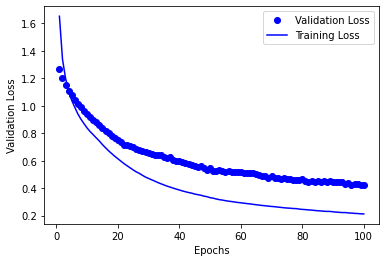

In [324]:
plt.plot(range(1, len(ave_val_loss_hist)+1)[:], ave_val_loss_hist[:], "bo", label="Validation Loss")
plt.plot(range(1, len(ave_val_loss_hist)+1)[:], ave_loss_hist[:], "b", label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()

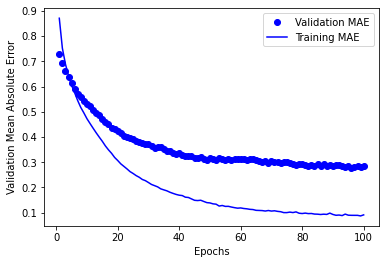

In [325]:
plt.plot(range(1, len(ave_val_mae_hist)+1)[:], ave_val_mae_hist[:], "bo", label="Validation MAE")
plt.plot(range(1, len(ave_val_mae_hist)+1)[:], ave_mae_hist[:], "b", label="Training MAE")
plt.xlabel("Epochs")
plt.ylabel("Validation Mean Absolute Error")
plt.legend()
plt.show()

**Building the best fit Model**

In [326]:
model = models.Sequential()
model.add(layers.Dense(32, kernel_regularizer=regularizers.l1( l1=0.001), activation = "relu", input_shape=(train_data.shape[1],)))
model.add(layers.Dense(10,kernel_regularizer=regularizers.l1( l1=0.001), activation="relu"))
model.add(layers.Dense(8,kernel_regularizer=regularizers.l1( l1=0.001), activation="relu"))
model.add(layers.Dense(6,kernel_regularizer=regularizers.l1( l1=0.001), activation="relu"))
model.add(layers.Dense(1))
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

**Training the model with all samples**

In [327]:
model.fit(train_data, train_labels, epochs=100)

Epoch 1/100
5/5 [==============================] - 1s 3ms/step - loss: 1.2060 - mae: 0.7462
Epoch 2/100
5/5 [==============================] - 0s 3ms/step - loss: 1.2089 - mae: 0.7547
Epoch 3/100
5/5 [==============================] - 0s 3ms/step - loss: 1.1111 - mae: 0.7057
Epoch 4/100
5/5 [==============================] - 0s 3ms/step - loss: 1.1708 - mae: 0.7373
Epoch 5/100
5/5 [==============================] - 0s 3ms/step - loss: 1.2762 - mae: 0.7551
Epoch 6/100
5/5 [==============================] - 0s 4ms/step - loss: 1.0797 - mae: 0.7073
Epoch 7/100
5/5 [==============================] - 0s 3ms/step - loss: 1.0604 - mae: 0.6847
Epoch 8/100
5/5 [==============================] - 0s 3ms/step - loss: 1.0250 - mae: 0.6670
Epoch 9/100
5/5 [==============================] - 0s 3ms/step - loss: 1.0194 - mae: 0.6765
Epoch 10/100
5/5 [==============================] - 0s 3ms/step - loss: 0.9483 - mae: 0.6395
Epoch 11/100
5/5 [==============================] - 0s 3ms/step - loss: 0.9074 

**Evaluating the Network**

In [328]:
test_loss_score, test_mae_score=model.evaluate(test_data, test_labels)

2/2 [==============================] - 0s 6ms/step - loss: 0.3164 - mae: 0.2821


In [329]:
test_mae_score

0.2821275591850281

**Predicting the values**

In [330]:
prediction=model.predict(test_data)

pred_norm=(prediction*std_new[-1])+mean_new[-1]
test_norm = (test_labels*std_new[-1])+mean_new[-1]

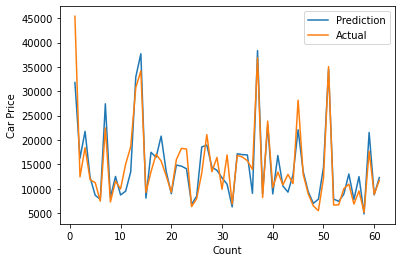

In [331]:
plt.plot(range(1, len(pred_norm[:])+1), pred_norm[:], label="Prediction")
plt.plot(range(1, len(pred_norm[:])+1), test_norm[:], label="Actual")
plt.xlabel("Count")
plt.ylabel("Car Price")
plt.legend()
plt.show()